# ML-Leaks Adversary 3

## Imports

In [12]:
import sys 
import numpy as np 
import matplotlib.pyplot as plt


import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

sys.path.insert(0, '../../../Utils/')

import models
from train import *
from metrics import * 

#audio
import librosa as libr
from torch.utils.data import Dataset, DataLoader

print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

# determine device to run network on (runs on gpu if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Python: 3.6.5 (default, Jul  6 2018, 19:12:46) 
[GCC 5.4.0 20160609]
Pytorch: 0.4.0


## Hyperparameters

In [13]:
n_epochs = 25
batch_size = 256
lr = 0.001

transform_type = 'SFTF' #either STFT or MFCC  

if transform_type == 'SFTF':
    target_net_type = models.STFT_CNN_classifier
    in_size = 94# 20 forMFCC,  94 for STFT
elif transform_type == 'MFCC':
    target_net_type = models.audio_CNN_classifier
    in_size = 20

## Load LibriSpeech

In [14]:
### Hyperparameters

n_seconds = 3
sampling_rate = 16000
number_of_mels =128
data_set = 360 #100 or 360
if data_set == 100:
    all_data = ['train-clean-100']
elif data_set == 360:
    all_data = ['train-clean-360']
lr = 0.001

### Speech preprocessing

class tensorToMFCC:
    def __call__(self, y):
#         y = y.numpy()
        dims = y.shape
        y = libr.feature.melspectrogram(np.reshape(y, (dims[1],)), 16000, n_mels=number_of_mels,
                               fmax=8000)
        y = libr.feature.mfcc(S = libr.power_to_db(y))
        y = torch.from_numpy(y)                           
        return y.float()
    
    
class STFT:
    def __call__(self,y):
        dims = y.shape
        y = np.abs(libr.core.stft(np.reshape(y, (dims[1],))))
        y = torch.from_numpy(y).permute(1,0)
        return y.float()
    
    
if transform_type == 'SFTF':
    transform  = STFT() ## STFT or MFCC
elif transform_type == 'MFCC':
    transform  = tensorToMFCC()

### Data set

%load_ext autoreload
%autoreload 2
sys.path.insert(0, './../../../Utils')
from datasets import LibriSpeechDataset
from datasets import Libri_preload_and_split

path = './../../../Classification_baselines/LibriSpeech/data/'

splits = [0.8, 0.2] #input fraction of data you want partitioned. Train, test fraction

trained_on = 3

if trained_on == 3: #train & attack a network with as much data as possible

    attacking = 3 #0 for no attack, 1 for attack 1, 3 for attack 3
    # attacking means data for a target & shadow network.
    # This will also split "out data" from totally different speakers -- data none of the 
    # other networks have seen, for training & testing the attack network. This will be
    # an equivalent amount of data to the train split as defined about

    if sum(splits) != 1:
        print('error: splits do not sum to 1.')

    #Splits data into 2 sets of speakers for target & shadow network, into above defined train:test splits
    dfs = Libri_preload_and_split(path,all_data,n_seconds,pad=False,cache=True,splits=splits, attacking = attacking)  

    #target train & test
    valid_sequence_train = LibriSpeechDataset(path, df = dfs[0], seconds = n_seconds, downsampling=1, 
                                        transform = transform, stochastic=False)

    valid_sequence_test = LibriSpeechDataset(path, df = dfs[1], seconds = n_seconds, downsampling=1, 
                                        transform = transform, stochastic=False)

    #out-data

    valid_sequence_out = LibriSpeechDataset(path, df = dfs[2], seconds = n_seconds, downsampling=1, 
                                        transform = transform, stochastic=False)


elif trained_on == 1: #take model + data splits from attack 1, to compare success of this attack w/identical data
    
    attacking = 1 #0 for no attack, 1 for attack 1, 3 for attack 3
    # attacking means data for a target & shadow network.
    # This will also split "out data" from totally different speakers -- data none of the 
    # other networks have seen, for training & testing the attack network. This will be
    # an equivalent amount of data to the train split as defined about

    if sum(splits) != 1:
        print('error: splits do not sum to 1.')

    #Splits data into 2 sets of speakers for target & shadow network, into above defined train:test splits
    dfs = Libri_preload_and_split(path,all_data,n_seconds,pad=False,cache=True,splits=splits, attacking = attacking)  

    
    #target train & test
    valid_sequence_train = LibriSpeechDataset(path, df = dfs[0], seconds = n_seconds, downsampling=1, 
                                        transform = transform, stochastic=False)

    valid_sequence_test = LibriSpeechDataset(path, df = dfs[1], seconds = n_seconds, downsampling=1, 
                                        transform = transform, stochastic=False)

    valid_sequence_out = LibriSpeechDataset(path, df = dfs[4], seconds = n_seconds, downsampling=1, 
                                        transform = transform, stochastic=False)

    valid_sequence_out_shadow = LibriSpeechDataset(path, df = dfs[5], seconds = n_seconds, downsampling=1, 
                                        transform = transform, stochastic=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Initialising LibriSpeechDataset with minimum length = 3s and subsets = ['train-clean-360']
Finished indexing data. 101703 usable files found.
45404
11607
44692
0
Finished splitting data.


In [15]:
# Loaders for data for target model & shadow model 
target_train_loader = DataLoader(valid_sequence_train,
                      batch_size=32,
                      shuffle=True,
                      num_workers=8
                     # pin_memory=True # CUDA only
                     )

target_out_loader = DataLoader(valid_sequence_out,
                      batch_size=32,
                      shuffle=True,
                      num_workers=8
                     # pin_memory=True # CUDA only
                     )

target_test_loader = DataLoader(valid_sequence_test,
                      batch_size=32,
                      shuffle=True,
                      num_workers=8
                     # pin_memory=True # CUDA only
                     )

## ML Leaks Adversary 3 (Membership Inference Attack) 
### https://arxiv.org/abs/1806.01246

In [16]:
# the model being attacked (architecture can be different than shadow)

n_hidden = 512
n_classes = valid_sequence_test.num_speakers
print(n_classes)

target_net = target_net_type(in_size,n_hidden,n_classes).to(device)
target_net.apply(models.weights_init)

#target_net.avgpool = nn.AvgPool2d(2, stride=1)
#target_net = models.mlleaks_cnn().to(device)

target_loss = nn.CrossEntropyLoss()
target_optim = optim.Adam(target_net.parameters(), lr=lr)

511


In [17]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')
        
epoch = n_epochs-1

In [18]:
if trained_on == 3:

#     chpt = torch.load('model_weights/CNN_voice_classifier'+str(data_set)+'_attack3_'+transform_type+str(epoch)+'.pth')
#     target_net.load_state_dict(chpt['state_dict'])
    
    train(target_net, target_train_loader, target_test_loader, target_optim, target_loss, n_epochs, verbose=False)

    save_checkpoint({
        'epoch': epoch,
        'arch': 'CNN_voice_classifier',
        'state_dict': target_net.state_dict(),
        'optimizer' : target_optim.state_dict(),
    }, False, filename = 'model_weights/CNN_voice_classifier'+str(data_set)+'_attack3_'+transform_type+str(epoch)+'.pth')

[0/25]
Training:

Accuracy = 99.24 %


Test:

Accuracy = 90.14 %


[1/25]
Training:

Accuracy = 99.24 %


Test:

Accuracy = 90.34 %


[2/25]
Training:

Accuracy = 98.41 %


Test:

Accuracy = 88.11 %


[3/25]
Training:

Accuracy = 98.67 %


Test:

Accuracy = 89.71 %


[4/25]
Training:

Accuracy = 99.29 %


Test:

Accuracy = 90.15 %


[5/25]
Training:

Accuracy = 98.57 %


Test:

Accuracy = 88.85 %


[6/25]
Training:

Accuracy = 98.22 %


Test:

Accuracy = 87.95 %


[7/25]
Training:

Accuracy = 98.79 %


Test:

Accuracy = 89.12 %


[8/25]
Training:

Accuracy = 99.50 %


Test:

Accuracy = 90.63 %


[9/25]
Training:

Accuracy = 99.02 %


Test:

Accuracy = 89.44 %


[10/25]
Training:

Accuracy = 98.73 %


Test:

Accuracy = 89.23 %



Accuracy = 99.21 %


Test:

Accuracy = 89.87 %


[12/25]
Training:

Accuracy = 99.52 %


Test:

Accuracy = 90.39 %


[13/25]
Training:

Accuracy = 99.08 %


Test:

Accuracy = 89.94 %


[14/25]
Training:

Accuracy = 99.57 %


Test:

Accuracy = 91.26 %


[15/25]


In [7]:
if trained_on == 1:
    chpt = torch.load('model_weights/CNN_voice_classifier100_target_'+str(epoch)+'.pth')
    target_net.load_state_dict(chpt['state_dict'])

threshold = 0.5000, accuracy = 55.76, precision = 0.53, recall = 1.00
threshold = 0.5050, accuracy = 56.01, precision = 0.53, recall = 1.00
threshold = 0.5100, accuracy = 56.25, precision = 0.53, recall = 1.00
threshold = 0.5150, accuracy = 56.49, precision = 0.53, recall = 1.00
threshold = 0.5200, accuracy = 56.76, precision = 0.54, recall = 1.00
threshold = 0.5250, accuracy = 56.99, precision = 0.54, recall = 1.00
threshold = 0.5300, accuracy = 57.23, precision = 0.54, recall = 1.00
threshold = 0.5350, accuracy = 57.43, precision = 0.54, recall = 1.00
threshold = 0.5400, accuracy = 57.66, precision = 0.54, recall = 1.00
threshold = 0.5450, accuracy = 57.90, precision = 0.54, recall = 1.00
threshold = 0.5500, accuracy = 58.19, precision = 0.54, recall = 1.00
threshold = 0.5550, accuracy = 58.44, precision = 0.55, recall = 1.00
threshold = 0.5600, accuracy = 58.69, precision = 0.55, recall = 1.00
threshold = 0.5650, accuracy = 58.93, precision = 0.55, recall = 1.00
threshold = 0.5700, 

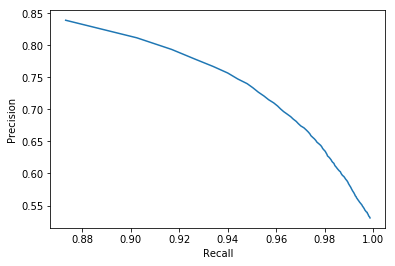

In [10]:
eval_membership_inference(target_net, target_train_loader, target_out_loader)